In [1]:
#Librerias
import pandas as pd
import numpy as np
import cobra
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy import stats
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import requests
import time

from scipy.stats import mannwhitneyu 

/tmp/ipykernel_410087/2159061748.py:11: UserWarning: DelftStack
  warnings.warn('DelftStack')


In [2]:
#Cargar archivos con pandas
fpkm=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/KuangRNAseq_fpkm", sep="\t",index_col=0)
atac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/GSE101290_normalized_atac_counts.csv",index_col=0)
OX= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangOX.txt", sep="\t")
RB= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRB.txt", sep="\t")
RC= pd.read_csv("/home/bguzman/jupyter/UI/YMC/data/kuangRC.txt", sep="\t")
SAM=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME.csv", index_col=0)
ACOA=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC.csv")
SAM_glc=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME_glc.csv",index_col=0)
ACOA_glc=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC_glc.csv",index_col=0)
SAM_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME_allflux.csv",index_col=0)
ACOA_all=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC_allflux.csv",index_col=0)
SAM_o2=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorME_o2scaled.csv",index_col=0)
ACOA_o2=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/vectores_febrero2023/vectorAC_o2scaled.csv",index_col=0)
H3K9ac=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_all_ac.csv", index_col=0)
H3K4me3=pd.read_csv("/home/bguzman/jupyter/UI/YMC/analysis/dfi_T_all.csv", index_col=0)




In [3]:
#Separar las listas de cada etapa
#Dejar solo las columnas de RNA-seq y excluir las de microarrays
df_fpkm=fpkm.iloc[0:-2,-16::] 

In [4]:
#Sacar promedio entre los diferentes elementos de los replicados 1, 2; 3, 4; 5 , 6.
genes=atac.index
T1=list((atac.iloc[: , 1].values+atac.iloc[: , 2].values)/2)
T2=list((atac.iloc[: , 3].values+atac.iloc[: , 4].values)/2)
T3=list((atac.iloc[: , 5].values+atac.iloc[: , 6].values)/2)
T4=list((atac.iloc[: , 7].values+atac.iloc[: , 8].values)/2)
T5=list((atac.iloc[: , 9].values+atac.iloc[: , 10].values)/2)
T6=list((atac.iloc[: , 11].values+atac.iloc[: , 12].values)/2)

In [5]:
#Hacer df apartir de las listas realizadas con los promedios de los replicados
import pandas as pd
import numpy as np
lst1 = genes
#lst2 = T1
#lst3= T2
#lst4= T3
#lst5= T4
#lst6= T5
#lst7= T6
lst2 = T2 # RC
lst3= T3  # OX
lst4= T4  # OX
lst5= T5  # RB
lst6= T6  # RB
lst7= T1  # RC
atac_prom = pd.DataFrame(list(zip(lst1,lst2,lst3,lst4,lst5,lst6,lst7)), columns = ['Genes','T1','T2','T3','T4','T5','T6'])
#fijar como indice la columna de los gene.id para hacer el heatmap
df_atac = atac_prom.set_index(['Genes'])
#df_atac

In [6]:
df_atac

,T1,T2,T3,T4,T5,T6
Genes,,,,,,
YAL054C,940.148091,887.670807,931.008217,1028.228049,1138.881514,1123.872359
YAL049C,109.752696,81.470473,94.609206,107.402953,113.632051,137.602661
YAL047C,141.070681,130.633866,159.257119,172.388267,152.747868,145.534681
YAL046C,258.911966,277.472202,312.935968,285.958657,256.942021,265.755266
YAL044C,337.265677,370.096556,406.347668,405.636631,352.574266,397.052214
...,...,...,...,...,...,...
YIR025W,131.656887,126.185219,164.319749,162.519828,153.778863,132.508955
YIR029W,165.639998,186.068545,212.938410,202.618056,176.510730,135.630250
YIR033W,807.699662,815.896083,853.903625,811.599598,819.370826,848.068705


In [7]:
#Definir listas con los genes por etapa 
lista_RC=list(RC.iloc[0:-2,0])
lista_OX=list(OX.iloc[0:-2,0])
lista_RB=list(RB.iloc[0:-2,0])

In [8]:
#Listas de etapas en atac-seq
list_1=lista_RC
list_2=atac.index
from collections import Counter
cnt1 = Counter(list_1)
cnt2 = Counter(list_2)
lista_RB_ss= [key for key, counts in cnt2.items() if cnt1[key] == counts]

list_3=lista_OX
list_4=atac.index
from collections import Counter
cnt3 = Counter(list_3)
cnt4 = Counter(list_4)
lista_OX_ss= [key for key, counts in cnt4.items() if cnt3[key] == counts]

list_5=lista_RB
list_6=atac.index
from collections import Counter
cnt5 = Counter(list_5)
cnt6 = Counter(list_6)
lista_RB_ss= [key for key, counts in cnt6.items() if cnt5[key] == counts]

In [9]:
lista_RC_ss=[]
for gene in lista_RC:
    if gene in atac.index:
          lista_RC_ss.append(gene)

lista_OX_ss=[]
for gene in lista_OX:
    if gene in atac.index:
          lista_OX_ss.append(gene)
            
lista_RB_ss=[]
for gene in lista_RB:
    if gene in atac.index:
          lista_RB_ss.append(gene)

In [10]:
from scipy import stats
   
#Cálculo de la correlacion entre el precursor y la marca
def ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa):
    # subsets the dataframe
    df = marcaEpigenetica.loc[genesEtapa]
    # Computes the correlation
    corr=[]
    for i in range(len(df)):
        a = np.array(df.iloc[i,:])
        b = np.array(perfilPrecursor)[0]
        corr.append(stats.pearsonr(a,b)[0])
    #ordenar corrlacion demayor a menor
    df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
    corr_sort = df_corr.sort_values('correlation',ascending=False)

    return(corr_sort)


In [178]:

df = H3K4me3.loc[list(atac.index)]
corr_sort = ordenarDF(H3K4me3,  SAM_all, list(atac.index))
corr = corr_sort["correlation"].values[:]
df_corr=pd.DataFrame(corr,index =df.index,columns = ['correlation'])
df_corr

,correlation
gene_id,
YAL054C,0.932921
YAL049C,0.900805
YAL047C,0.900179
YAL046C,0.898410
YAL044C,0.897836
...,...
YIR025W,-0.805278
YIR029W,-0.840809
YIR033W,-0.866462


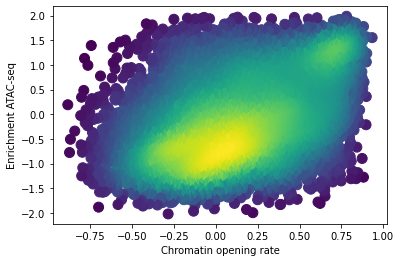

In [25]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

plt.savefig("corr_1me_all.svg")


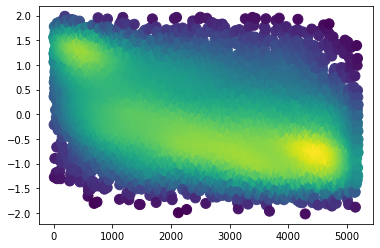

In [184]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = range(dfx["T1"].size)
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
#plt.savefig("sp_1me_all.svg")



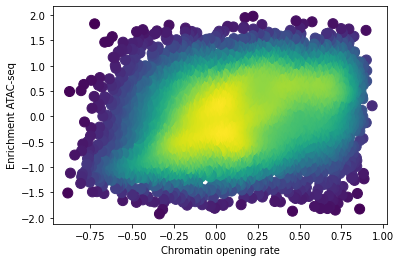

In [26]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

plt.savefig("corr_2me_all.svg")

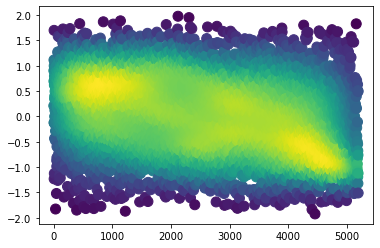

In [46]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T2"].size)
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_2me_all.svg")

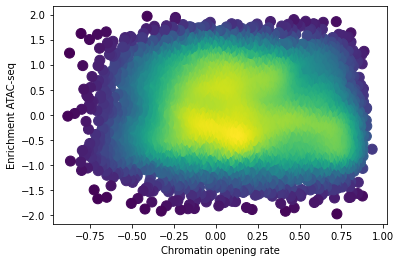

In [27]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

plt.savefig("corr_3me_all.svg")

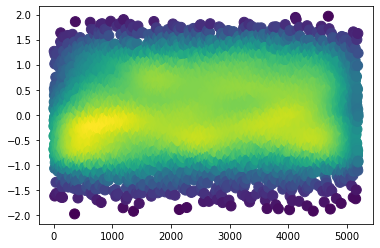

In [47]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T3"].size)
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_3me_all.svg")

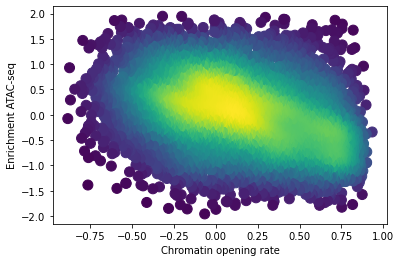

In [28]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

plt.savefig("corr_4me_all.svg")

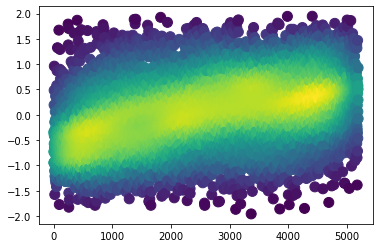

In [48]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T4"].size)
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_4me_all.svg")

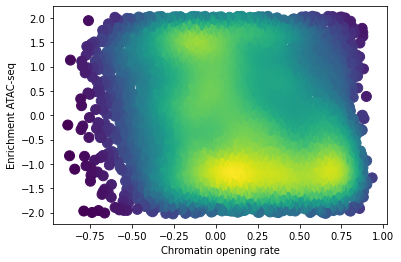

In [29]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 

plt.savefig("corr_5me_all.svg")

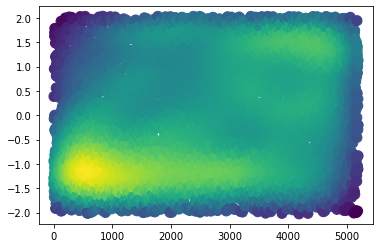

In [49]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T5"].size)
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_5me_all.svg")

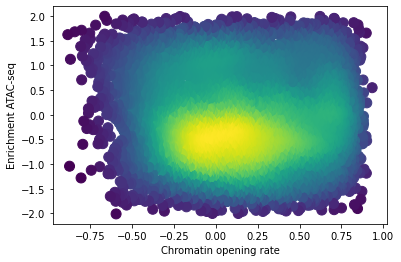

In [30]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)
corrs = genesEtapa_ordenados["correlation"].values[:]

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Fonts
#plt.rcParams['font.family'] = 'cmr10'  # o 'cmr12' o 'cmr17' para la fuente Computer Modern

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_6me_all.svg")

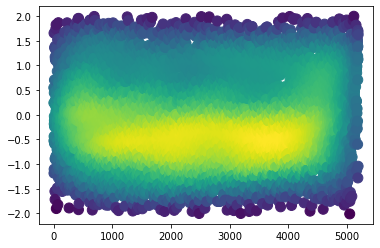

In [50]:
marcaEpigenetica= H3K4me3
perfilPrecursor= SAM_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T6"].size)
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_6me_all.svg")

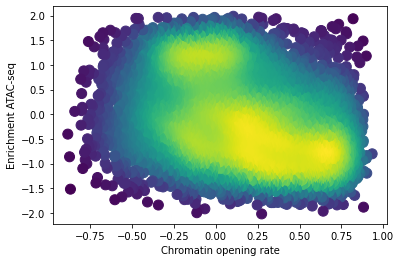

In [31]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_1ac_all.svg")

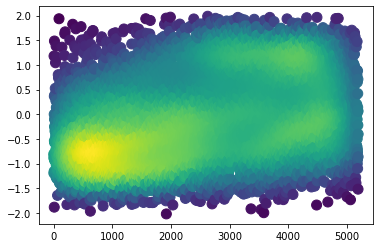

In [51]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = range(dfx["T1"].size)
y = dfx["T1"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_1ac_all.svg")


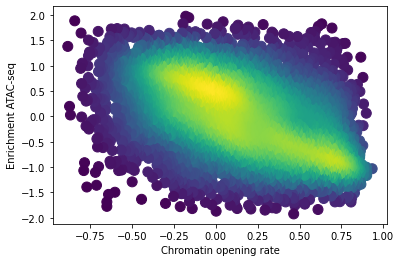

In [32]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_2ac_all.svg")

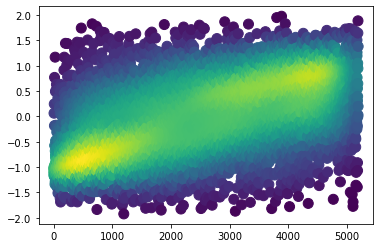

In [52]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
x = range(dfx["T2"].size)
y = dfx["T2"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_2ac_all.svg")

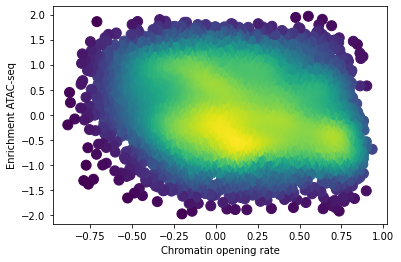

In [33]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_3ac_all.svg")

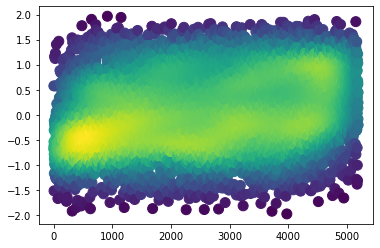

In [53]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T3"].size)
y = dfx["T3"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_3ac_all.svg")

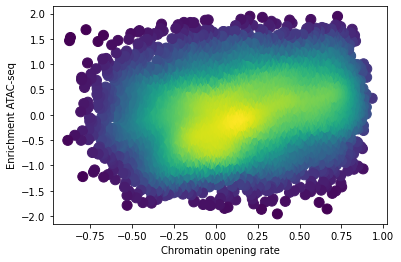

In [34]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_4ac_all.svg")

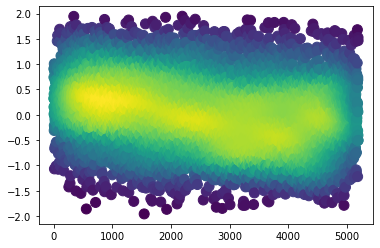

In [54]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
# Generate data
x = range(dfx["T4"].size)
y = dfx["T4"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_4ac_all.svg")

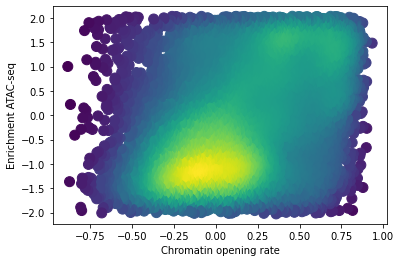

In [35]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T5"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_5ac_all.svg")

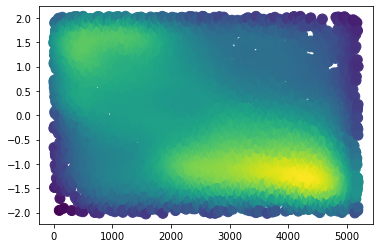

In [55]:
# Generate data
x = range(dfx["T5"].size)
y = dfx["T5"]
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_5ac_all.svg")

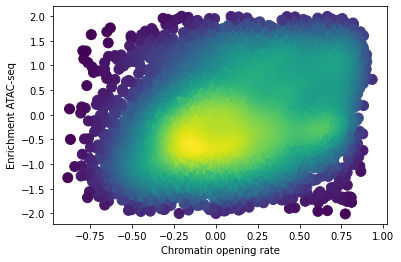

In [36]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde


# Generate data
x = corrs
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.xlabel("Chromatin opening rate")
plt.ylabel("Enrichment ATAC-seq") 
plt.savefig("corr_6ac_all.svg")

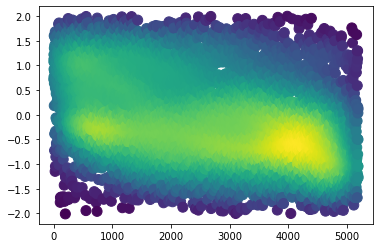

In [56]:
marcaEpigenetica= H3K9ac
perfilPrecursor= ACOA_all

timeT=[]
for i in range(1,7):
    timeT.append("T"+str(i))

genesEtapa = list(atac.index)
genesEtapa_ordenados = ordenarDF(marcaEpigenetica,perfilPrecursor,genesEtapa)

dfx=df_atac.loc[genesEtapa_ordenados.index].apply(lambda x: (x-x.mean())/x.std(), axis = 1)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
x = range(dfx["T6"].size)
y = dfx["T6"]

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=100)
plt.savefig("sp_6ac_all.svg")